We will once again use our university admission dataset

First, let's understand how our independent variables are correlated to each other

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

%matplotlib inline 

Exploring the dataset 

In [2]:
data=pd.read_csv('../uni_admission.csv')

In [17]:
# Remove the serial and admit chance columns, we want to focus on our independent variables only.
independent_only = data.drop(columns=['Serial No.', 'admit_chance'])

In [18]:
#Lets display the correlation only if the correlation is not zero.


# Let's display the correlations between the variables
correlations = independent_only.corr()

<AxesSubplot:>

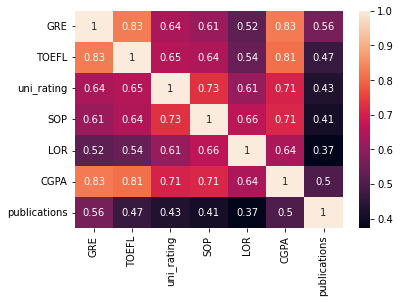

In [5]:
#We can show this with a heat map

sns.heatmap(independent_only.corr(), annot=True)

The tabe above shows us how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. Let's use these correlations to compute the VIF score for each variable. This will require a little bit of linear algebra, but the approach is straightforward: we create a new dataframe with the *inverse* of the matrix above.

In [19]:
pd.DataFrame(np.linalg.inv(correlations.values), index=correlations.index, columns=correlations.index)

,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,publications
GRE,4.464249,-1.919309,-0.167441,0.115539,0.163716,-1.829666,-0.738214
TOEFL,-1.919309,3.904213,-0.280590,-0.320530,0.008925,-1.216918,0.115389
uni_rating,-0.167441,-0.280590,2.621036,-1.003439,-0.326820,-0.504916,-0.109544
SOP,0.115539,-0.320530,-1.003439,2.835210,-0.715324,-0.670228,-0.041512
LOR,0.163716,0.008925,-0.326820,-0.715324,2.033555,-0.650578,-0.096312
CGPA,-1.829666,-1.216918,-0.504916,-0.670228,-0.650578,4.777992,-0.064604
publications,-0.738214,0.115389,-0.109544,-0.041512,-0.096312,-0.064604,1.494008


In [20]:
revised = independent_only.drop(columns=['CGPA'])

correlations = revised.corr()
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)



,GRE,TOEFL,uni_rating,SOP,LOR,publications
GRE,3.763604,-2.385311,-0.360792,-0.141115,-0.085414,-0.762953
TOEFL,-2.385311,3.594274,-0.409188,-0.491232,-0.156772,0.098934
uni_rating,-0.360792,-0.409188,2.567679,-1.074266,-0.395570,-0.116371
SOP,-0.141115,-0.491232,-1.074266,2.741195,-0.806583,-0.050574
LOR,-0.085414,-0.156772,-0.395570,-0.806583,1.944971,-0.105109
publications,-0.762953,0.098934,-0.116371,-0.050574,-0.105109,1.493134


# Example 2: Residual plots and heteroskedasticity testing

Let's start by creating a model based on our revised set of independent variables above, then displaying the residual plot for it.

In [21]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [25]:
X=revised.values


500

In [10]:
y=data['admit_chance'].values

In [11]:
X_train, X_test, admit_train, admit_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
regressor=LinearRegression()
regressor.fit(X_train,admit_train)

LinearRegression()

In [28]:
# This is our prediction for admission based on our model
admit_predict = regressor.predict(X_test)

# We now create the residual by substracting the test value from the predicted 
# value for each row in our dataset

residuals = np.subtract(admit_predict, admit_test)

# Let's describe our residual:
pd.DataFrame(residuals).describe()

residuals.mean()

-0.0017516644688064865

Before we interpret the description above, let's recall what we are trying to predict: The percentage chance of admission to university. This means values between 0 and 1. 

Our min and max for the residual are fairly high: they suggest we've been up to 26% off target. It's important for us to plot this first: Is this a common occurence, or a few outliers?

Our mean on the other hand is close to 0, indicating that we tend to be fairly correct, although slightly over estimating chances by, on average, 0.17%

Let's show the residual plot

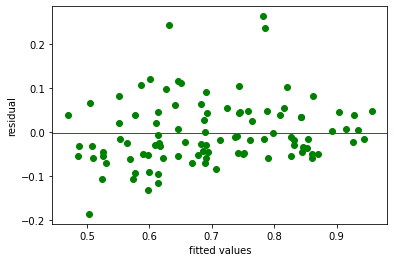

In [30]:
import matplotlib.pyplot as plt

plt.scatter(admit_predict, residuals, color='green')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

This does not look too bad: our residuals are centered around a mean that is very close to 0, and there are no glaringly obvious patterns. Let's be thorough though, and perform a heteroskedasticity test.

For this we will use [bartlett's test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm). The test establishes as a null hypothesis that the variance is equal for all our datapoints,and the new hypothesis that the variance is different for at least one pair of datapoints.

In [31]:
import scipy as sp 

test_result, p_value = sp.stats.bartlett(admit_predict, residuals)

test_result, p_value = sp.stats.bartlett(admit_predict, residuals)

degree_of_freedom=len(admit_predict)-1

In [39]:
import scipy as sp

test_result, p_value = sp.stats.bartlett(admit_predict, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(admit_predict)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)
print(critical_value)

# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')


185.4720823514965
the variances are homogeneous!
